<a href="https://www.kaggle.com/code/lonnieqin/single-cell-perturbation-with-conv1d?scriptVersionId=148099172" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Single-Cell Perturbation with Conv1D

## Import Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
import nltk
import gc

## Configuration

In [2]:
class Config:
    batch_size = 32
    vocab_size  = 0
    epochs = 50
    maxlen = 6
    use_k_fold = True
    
    dataset_path = "/kaggle/input/open-problems-single-cell-perturbations"
    
    _target_columns = None
    
    def target_columns(self):
        if self._target_columns == None:
            submission = pd.read_csv(f"{config.dataset_path}/sample_submission.csv")
            self._target_columns = list(submission.columns)
            self._target_columns.remove("id")
        return self._target_columns
config = Config() 

## Loading data

In [3]:
train = pd.read_parquet(f"{config.dataset_path}/de_train.parquet")
train.head()

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629


In [4]:
test = pd.read_csv(f"{config.dataset_path}/id_map.csv")
test.head()

,id,cell_type,sm_name
0,0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,1,B cells,ABT-199 (GDC-0199)
2,2,B cells,ABT737
3,3,B cells,AMD-070 (hydrochloride)
4,4,B cells,AT 7867


## Preprocessing

In [5]:
train["text"] = (train["cell_type"] + " " + train["sm_name"]).apply(lambda sentence: " ". join(nltk.word_tokenize(sentence.lower())))
test["text"] = (test["cell_type"] + " " + test["sm_name"]).apply(lambda sentence: " ". join(nltk.word_tokenize(sentence.lower())))
vectorizor = keras.layers.TextVectorization(output_sequence_length=config.maxlen)
vectorizor.adapt(train["text"])

In [6]:
config.vcoab_size = len(vectorizor.get_vocabulary())
config.vcoab_size

184

In [7]:
## Vocabulary
vectorizor.get_vocabulary()

['',
 '[UNK]',
 'cells',
 't',
 'regulatory',
 'nk',
 'cd4',
 'cd8',
 'myeloid',
 'b',
 'inhibitor',
 'bay',
 'r428',
 'porcn',
 'penfluridol',
 'palbociclib',
 'odemethylated',
 'mln',
 'linagliptin',
 'ldn',
 'iii',
 'idelalisib',
 'foretinib',
 'dactolisib',
 'dabrafenib',
 'crizotinib',
 'chir99021',
 'belinostat',
 'adapalene',
 '2238',
 '193189',
 'oprozomib',
 'onx',
 'alvocidib',
 '0912',
 'yk',
 'vorinostat',
 'vii',
 'vardenafil',
 'vanoxerine',
 'vandetanib',
 'uniibxu45zh6li',
 'trametinib',
 'tr14035',
 'tpca1',
 'tosedostat',
 'topotecan',
 'tlhras26',
 'tivozanib',
 'tivantinib',
 'tipifarnib',
 'tie2',
 'tgx',
 'tamatinib',
 'tak',
 'tacalcitol',
 'sunitinib',
 'stk219801',
 'sta9090',
 'slx2119',
 'sgccbp30',
 'selumetinib',
 'scriptaid',
 'sch58261',
 'sb525334',
 'saracatinib',
 'rvx208',
 'ruxolitinib',
 'rn486',
 'riociguat',
 'ricolinostat',
 'rg7112',
 'rg7090',
 'raloxifene',
 'quizartinib',
 'pyrimidin2amine',
 'prt062607',
 'protriptyline',
 'proscillaridina',

## Building Model

In [8]:
def mean_rowwise_rmse(y_true, y_pred):
    """
    Custom metric to calculate the Mean Rowwise Root Mean Squared Error (RMSE).

    Parameters:
    - y_true: The true target values.
    - y_pred: The predicted values.

    Returns:
    - Mean Rowwise RMSE as a scalar tensor.
    """
    return tf.reduce_mean(
        tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    )

def get_model():
    inputs = keras.Input(shape=(), dtype=tf.string)
    x = vectorizor(inputs)
    x = keras.layers.Embedding(config.vcoab_size, 32, input_length=config.maxlen)(x)
    x = keras.layers.Conv1D(filters=16, kernel_size=1, activation="swish")(x)
    x = keras.layers.SpatialDropout1D(0.1)(x)
    x = keras.layers.Conv1D(filters=32, kernel_size=1, activation="swish")(x)
    x = keras.layers.SpatialDropout1D(0.1)(x)
    x = keras.layers.Conv1D(filters=64, kernel_size=1, activation="swish")(x)
    x = keras.layers.SpatialDropout1D(0.1)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, kernel_initializer='he_uniform', activation='swish')(x)
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(256, kernel_initializer='he_uniform', activation='swish')(x)
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(512, kernel_initializer='he_uniform', activation='swish')(x)
    outputs = keras.layers.Dense(len(config.target_columns()))(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss="mse", optimizer="adam", metrics=[mean_rowwise_rmse])
    return model

In [9]:
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
text_vectorization (TextVect (None, 6)                 0         
_________________________________________________________________
embedding (Embedding)        (None, 6, 32)             5888      
_________________________________________________________________
conv1d (Conv1D)              (None, 6, 16)             528       
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 6, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 32)             544       
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 6, 32)             0     

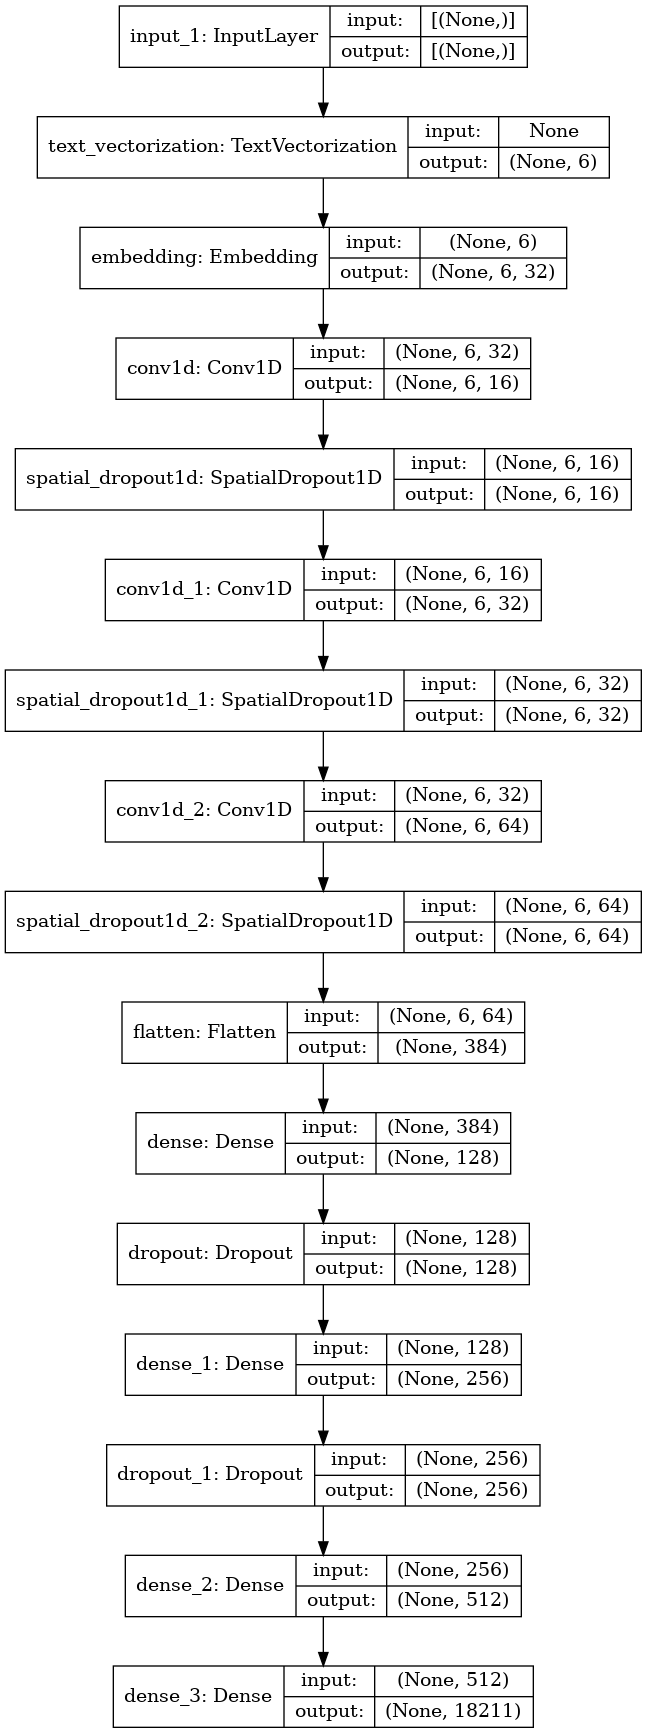

In [10]:
keras.utils.plot_model(model, show_shapes=True)

## Training models

In [11]:
keras.backend.clear_session()
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
models = []
rmses = []
for i, (train_indices, valid_indices) in enumerate(kfold.split(train, train["sm_name"])):
    x_train = train.iloc[train_indices]["text"]
    y_train = train.iloc[train_indices][config.target_columns()]
    x_val = train.iloc[valid_indices]["text"]
    y_val = train.iloc[valid_indices][config.target_columns()]
    model_path = f"model_{i}.tf"
    model = get_model()
    checkpoint = keras.callbacks.ModelCheckpoint(model_path, monitor="val_mean_rowwise_rmse", mode="min", save_best_only=True, save_weights_only=True)
    early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)
    history = model.fit(
        x_train, y_train, 
        batch_size=config.batch_size, 
        epochs=config.epochs,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint, early_stop],
        verbose=2
    )
    model.load_weights(model_path)
    result = model.evaluate(x_val, y_val)
    print("Loss:", result[0], "RMSE:", result[1])
    rmses.append(result[1])
    models.append(model) 
    if not config.use_k_fold:
        break
print(f"OOF:{np.mean(rmses)}")

Epoch 1/50
13/13 - 2s - loss: 5.5314 - mean_rowwise_rmse: 1.2509 - val_loss: 6.0451 - val_mean_rowwise_rmse: 1.3013
Epoch 2/50
13/13 - 0s - loss: 5.4172 - mean_rowwise_rmse: 1.2669 - val_loss: 5.7600 - val_mean_rowwise_rmse: 1.3991
Epoch 3/50
13/13 - 0s - loss: 5.3480 - mean_rowwise_rmse: 1.2832 - val_loss: 5.7641 - val_mean_rowwise_rmse: 1.3296
Epoch 4/50
13/13 - 0s - loss: 5.3115 - mean_rowwise_rmse: 1.3307 - val_loss: 5.7379 - val_mean_rowwise_rmse: 1.3228
Epoch 5/50
13/13 - 0s - loss: 5.3213 - mean_rowwise_rmse: 1.2567 - val_loss: 5.7356 - val_mean_rowwise_rmse: 1.3026
Epoch 6/50
13/13 - 0s - loss: 5.1983 - mean_rowwise_rmse: 1.2929 - val_loss: 5.4540 - val_mean_rowwise_rmse: 1.3535
Epoch 7/50
13/13 - 0s - loss: 4.8615 - mean_rowwise_rmse: 1.2722 - val_loss: 4.7885 - val_mean_rowwise_rmse: 1.3181
Epoch 8/50
13/13 - 0s - loss: 4.3334 - mean_rowwise_rmse: 1.2366 - val_loss: 4.6446 - val_mean_rowwise_rmse: 1.3025
Epoch 9/50
13/13 - 0s - loss: 4.0922 - mean_rowwise_rmse: 1.1690 - val_l

## Submission

In [12]:
preds = np.mean([model.predict(test["text"]) for model in models], axis=0)
submission_df = pd.DataFrame(preds, columns=config.target_columns())
submission_df["id"] = test["id"]
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,id
0,0.252278,0.138304,0.098376,0.156317,0.488011,0.510449,-0.030399,0.222397,-0.049830,0.031976,...,0.121142,-0.039864,0.199516,0.360370,0.264236,0.201140,0.099237,-0.138937,-0.049471,0
1,-0.013394,0.013903,0.004718,0.010594,0.052917,0.014264,-0.071248,0.112610,-0.067655,0.060728,...,-0.006734,-0.097324,0.005570,0.161472,0.110157,0.154693,0.094078,-0.149599,-0.057785,1
2,0.201508,0.146100,0.132533,0.129859,0.421202,0.600500,-0.041897,0.267990,0.009374,0.042180,...,0.102695,0.012346,0.140805,0.350624,0.281794,0.227019,0.164375,-0.216347,-0.031017,2
3,-0.097070,-0.056181,-0.064084,-0.034078,-0.073895,-0.212842,-0.081785,0.025221,-0.090455,0.085680,...,-0.068700,-0.183631,-0.052384,0.096059,0.021225,0.116878,0.035089,-0.102388,-0.100470,3
4,-0.005950,0.011822,0.001143,0.017250,0.065068,0.014827,-0.069858,0.107179,-0.068903,0.061106,...,-0.005649,-0.103693,0.010482,0.163516,0.108033,0.152199,0.086961,-0.143497,-0.062397,4
